## Load Image Data

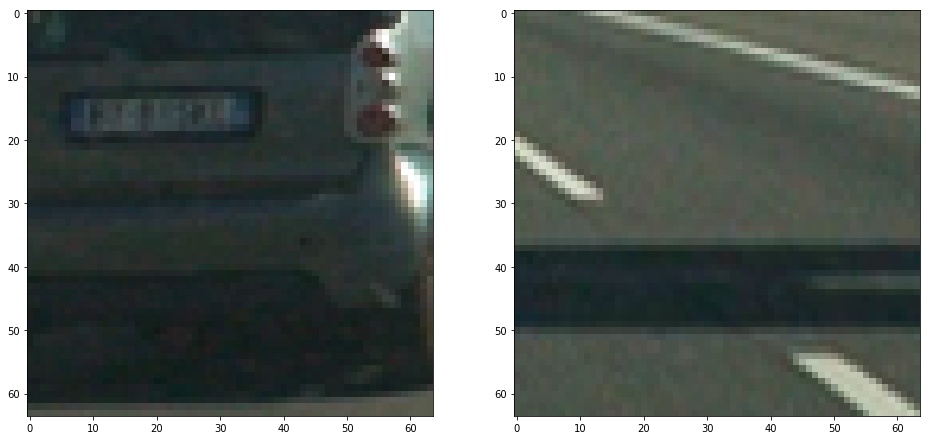

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.externals import joblib

from detection.helper import (
    load_training_data_rgb,
    extract_hog,
    hog_feature_vector,
    get_spacial_color_features,
    create_car_heatmap,
    draw_labeled_bboxes,
    CarDetectionPipeline
)

%matplotlib inline

vehicles, non_vehicles = load_training_data_rgb('data')

plt.figure(figsize=(16,16))
ax = plt.subplot(1,2,1)
plt.imshow(vehicles[0])
ax = plt.subplot(1,2,2)
plt.imshow(non_vehicles[0])
plt.show()

Want to double check all the images are in the same shape/format

In [2]:
set([img.shape for img in vehicles]), set([img.shape for img in non_vehicles])

({(64, 64, 3)}, {(64, 64, 3)})

All images are the same size: 64x64x3

# HOG Features

HOG stands for histogram of oriented gradients and gives a description of the orientations of the gradient in groups of pixel blocks.   In the image below you can see that the 64x64 vehicle of the car has 3 HOG's, one for each channel, that are done in 8x8 blocks.  For this project used 8 pixels for each cell, a histogram of the oriented gradiens, and using 9 direction. 

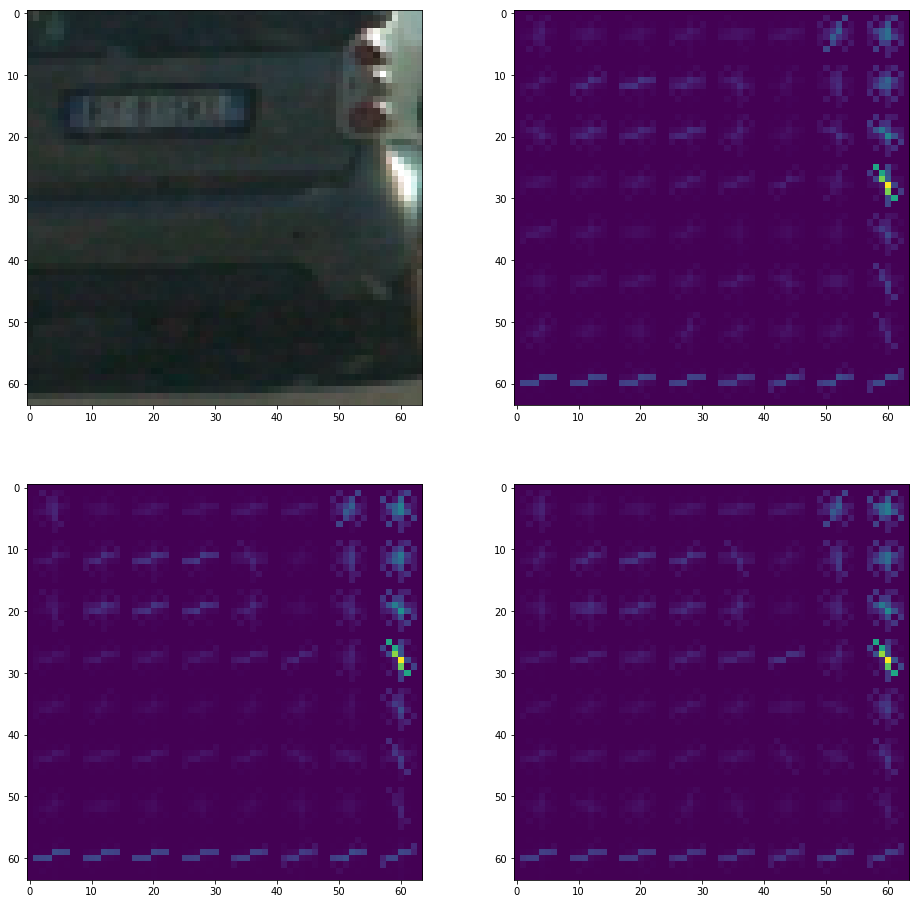

In [3]:
def plot_img_and_hog(img, cvt = None):
    plt.figure(figsize=(16,16))
    ax = plt.subplot(2,2,1)
    plt.imshow(img)

    if cvt is None:
        for i in range(3):
            features, hog_image = extract_hog(img[:,:,i],pix_per_cell = 8,orient = 9, vis=True,vector=False)
            ax = plt.subplot(2,2,2+i)
            plt.imshow(hog_image)
    else:
        for i in range(3):
            features, hog_image = extract_hog(cv2.cvtColor(img, cvt)[:,:,i],pix_per_cell = 8,orient = 9, vis=True,vector=False)
            ax = plt.subplot(2,2,2+i)
            plt.imshow(hog_image)
    plt.show()
    
plot_img_and_hog(vehicles[0])

The features for this look very similar in all channels.  Will try a different color space.

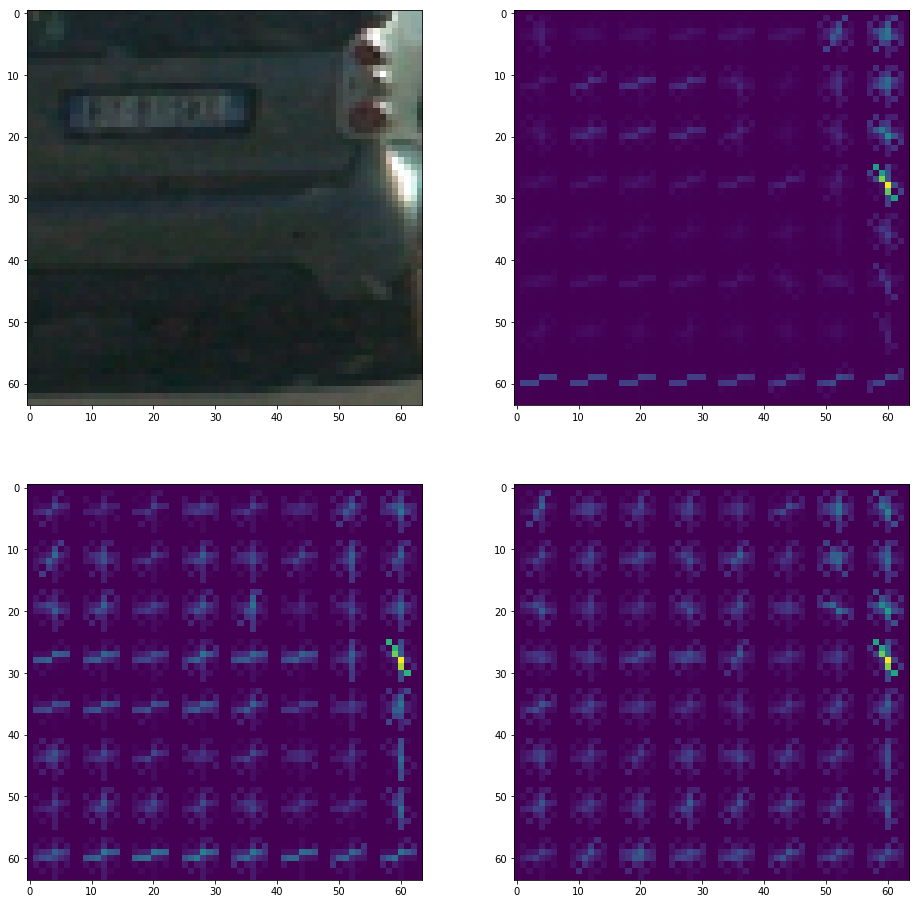

In [4]:
plot_img_and_hog(vehicles[0], cv2.COLOR_RGB2YUV)

## Create Feature Vectors For Training

I explored a number of features and color spaces, and found that using a collection of spacial/color features with RGB and hog with YCrCB color space produced some of the least amount of false positives in the video.  

In [5]:
vehicles_features = []
for v in tqdm(vehicles):
    vehicles_features.append(
        np.concatenate([
            get_spacial_color_features(v),
            hog_feature_vector(cv2.cvtColor(v, cv2.COLOR_RGB2YCrCb)),
        ])
    )
    
vehicles_features = np.array(vehicles_features)
vehicles_features.shape

100%|██████████| 8792/8792 [00:33<00:00, 265.62it/s]


(8792, 8460)

In [6]:
non_vehicles_features = []
for v in tqdm(non_vehicles):
    non_vehicles_features.append(
        np.concatenate([
            #get_spacial_color_features(cv2.cvtColor(v, cv2.COLOR_RGB2YCrCb)),
            get_spacial_color_features(v),
            hog_feature_vector(cv2.cvtColor(v, cv2.COLOR_RGB2YCrCb)),
        ])
    )
    
non_vehicles_features = np.array(non_vehicles_features)
non_vehicles_features.shape

100%|██████████| 8968/8968 [00:33<00:00, 271.32it/s]


(8968, 8460)

# Train Linear SVC Model

I originally explored feature selection methodolgies, but they always lead to selecting all of the features.  For the final training method I created a pipeline that had scaling and a Linear SVM.

In [7]:
labels = np.concatenate([
    np.ones((vehicles_features.shape[0],)),
    np.zeros((non_vehicles_features.shape[0],))
])

features = np.vstack([
    vehicles_features,
    non_vehicles_features
])

X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    test_size=0.20, 
    random_state=99999
)

In [16]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classify', LinearSVC())
])

parameters = {'classify__C':[0.00001, 0.00005, 0.0001, 0.0005, 0.001,0.005],}

clf = GridSearchCV(pipe, parameters,n_jobs=-1, cv=3, verbose=True)
clf.fit(X_train, y_train) 

matrix = confusion_matrix(y_test, clf.predict(X_test))
probs = (matrix / matrix.sum(axis=0))
probs = dict(zip(['tp','fp','fn','tn'], probs.ravel()))

clf.best_params_, clf.best_score_, accuracy_score(y_test, clf.predict(X_test)), roc_auc_score(y_test, clf.predict(X_test)), probs

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   59.2s finished


({'classify__C': 0.0005},
 0.98909065315315314,
 0.98986486486486491,
 0.9898634476263859,
 {'fn': 0.01001669449081803,
  'fp': 0.010256410256410256,
  'tn': 0.98974358974358978,
  'tp': 0.98998330550918201})

In [17]:

joblib.dump(clf, 'clf_best_svc.pkl')

['clf_best_svc.pkl']

# Test on Images

I implemented a video pipeline that uses a sliding window search over.  For each window I detech if a car is detected, and create a heat map.  This leads to a large number of false positive, so I also make a buffer of heatmaps, and require that the buffer sum is greater than a threshold.   I will give an example using the video.

In [2]:
from sklearn.externals import joblib
clf = joblib.load('clf_best_svc.pkl')

## Load Video Files


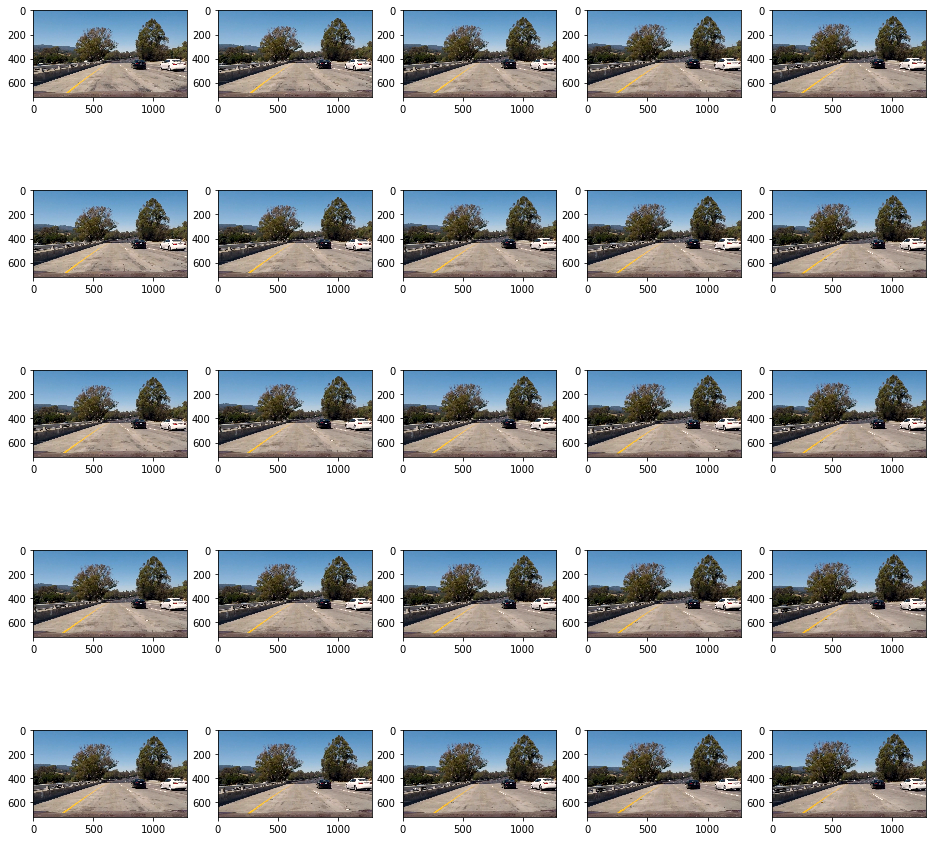

In [3]:
from skvideo.io import vread
cap = vread('project_video.mp4')

plt.figure(figsize=(16,16))
for i in range(5):
    for j in range(5):
        ax=plt.subplot(5,5,1+5*i+j)
        plt.imshow(cap[1000+i+j])

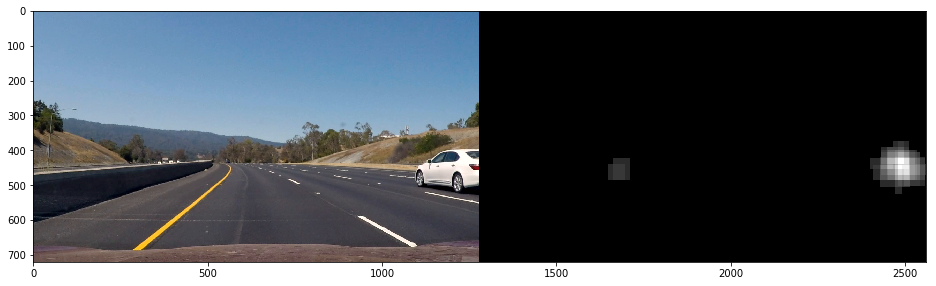

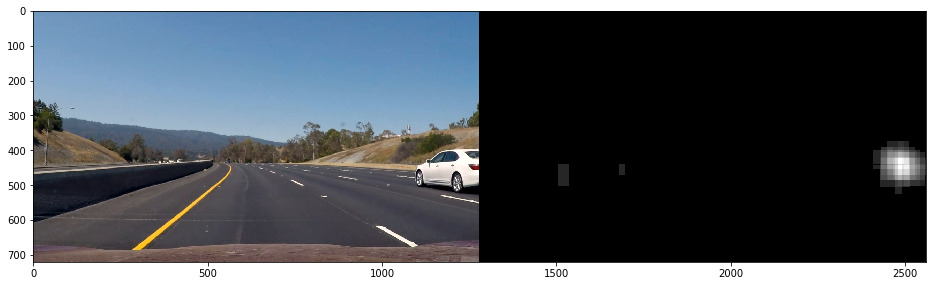

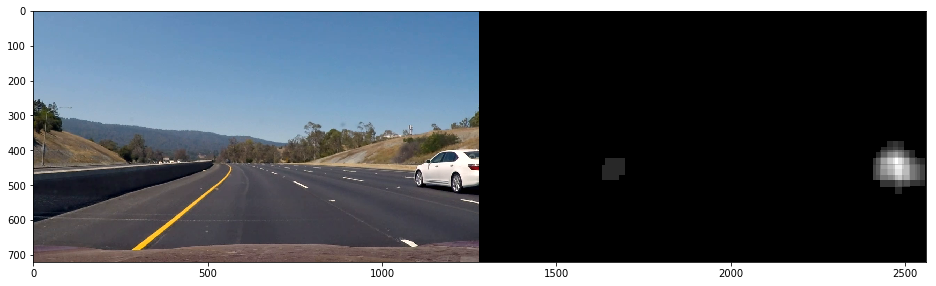

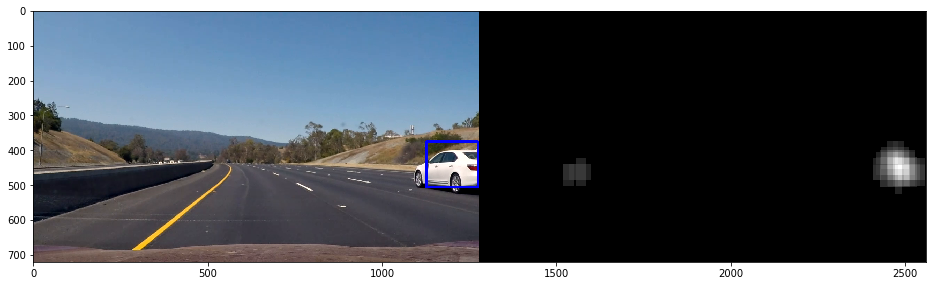

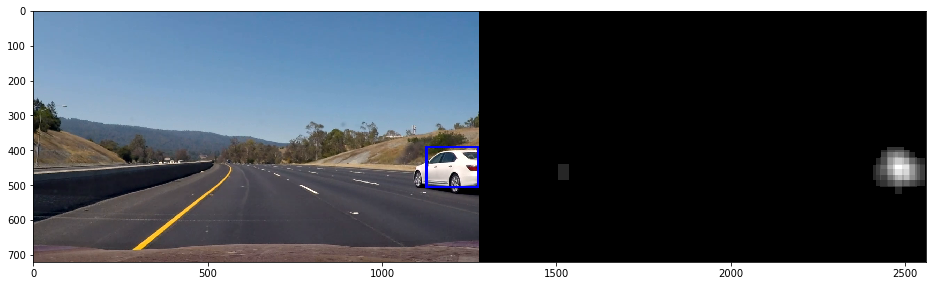

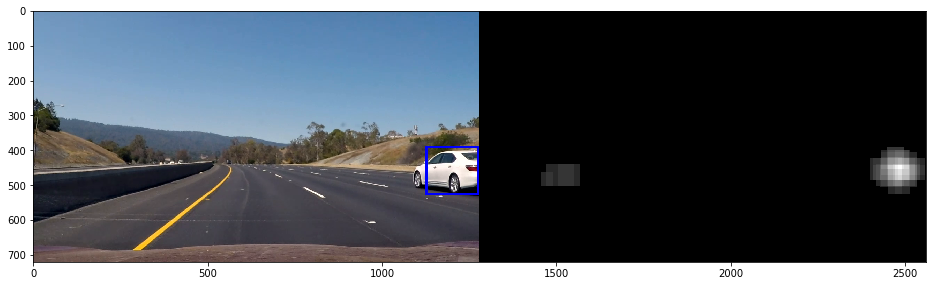

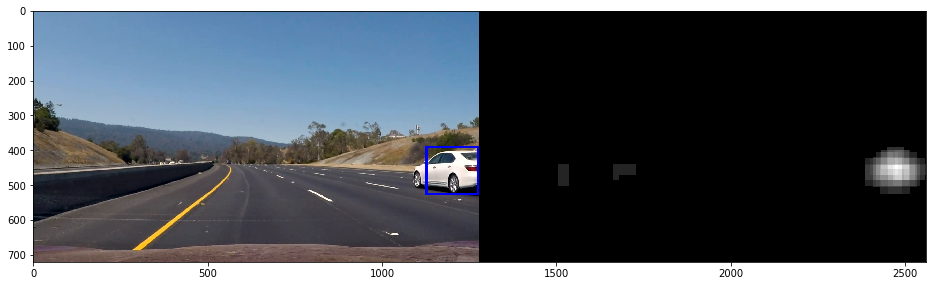

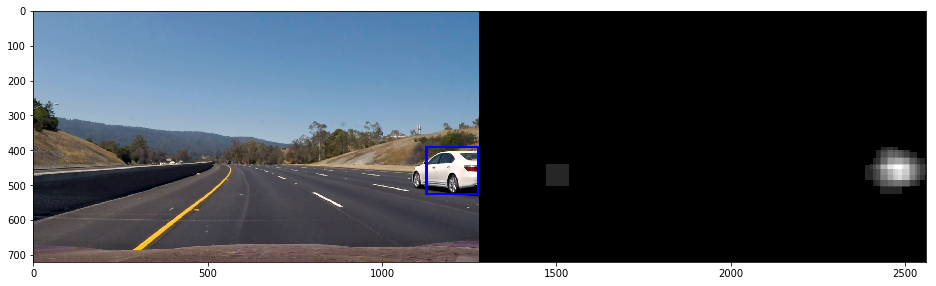

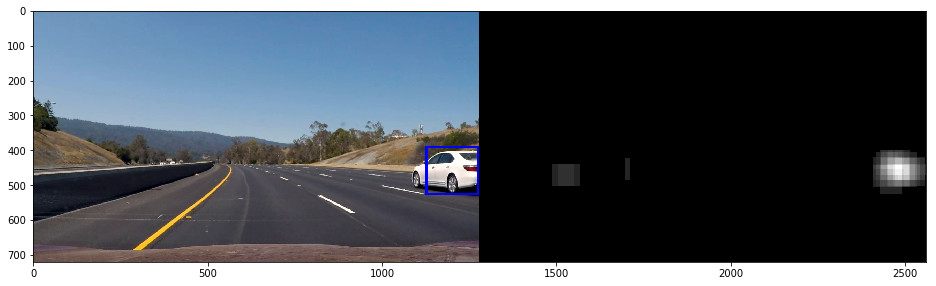

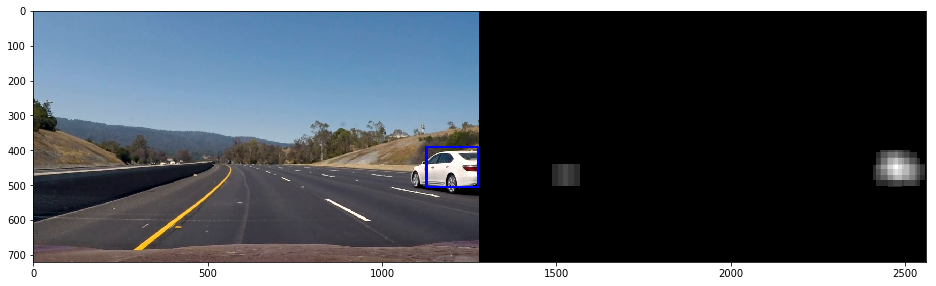

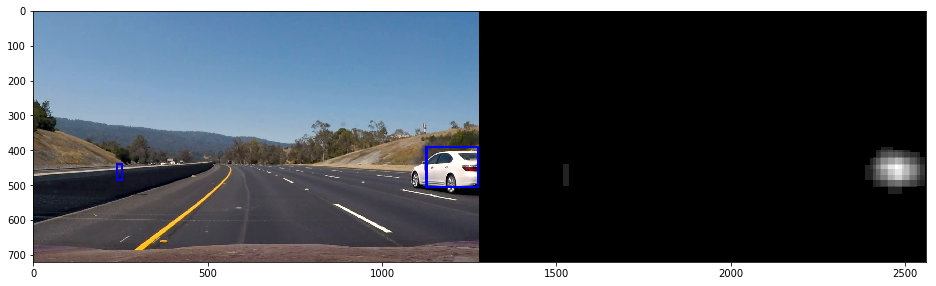

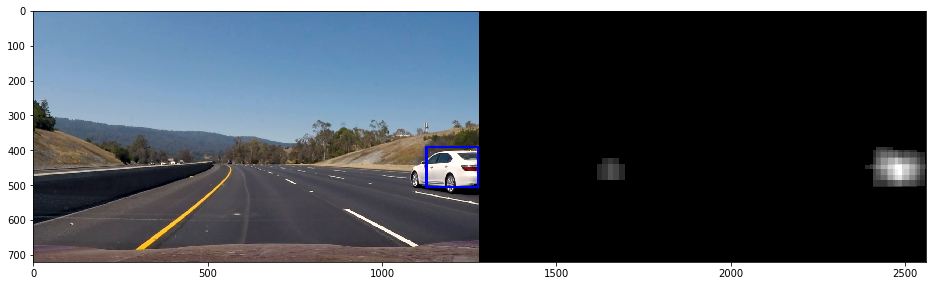

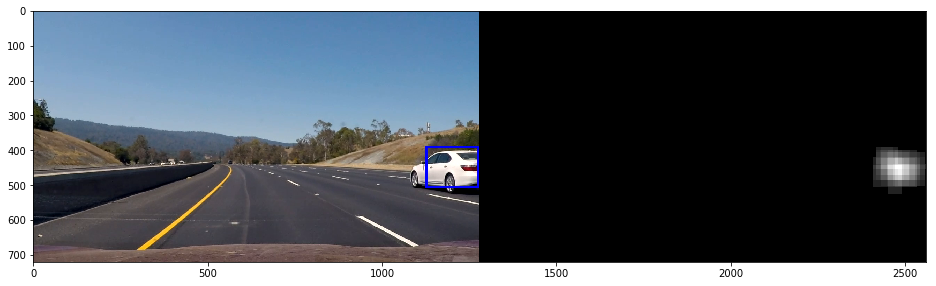

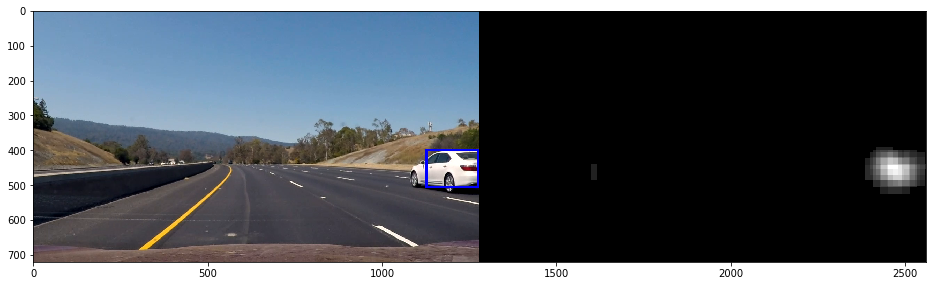

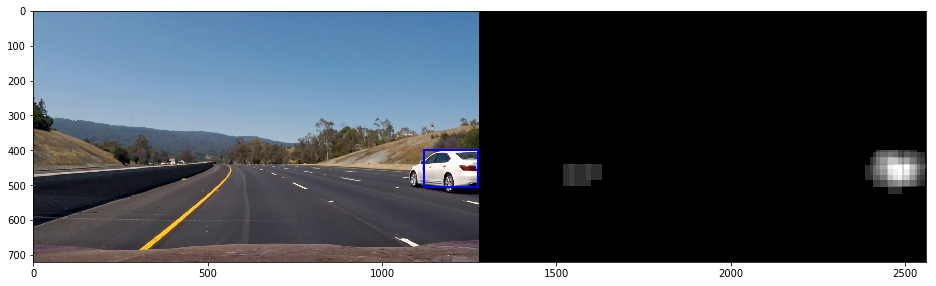

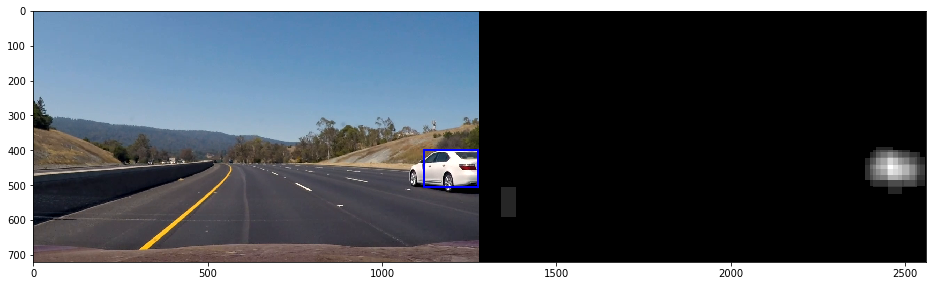

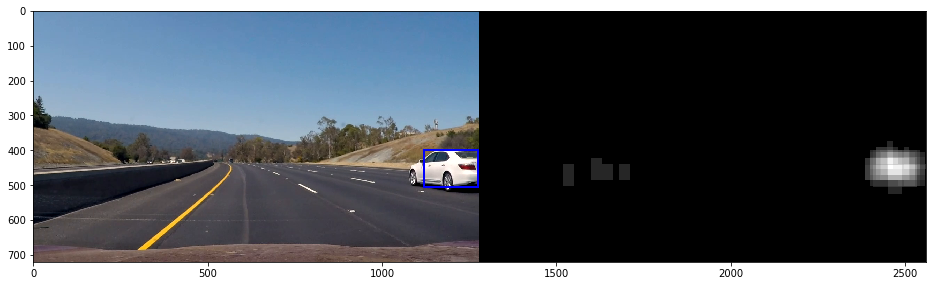

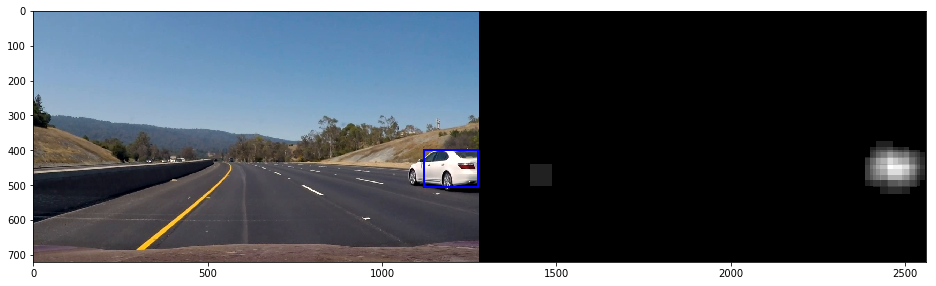

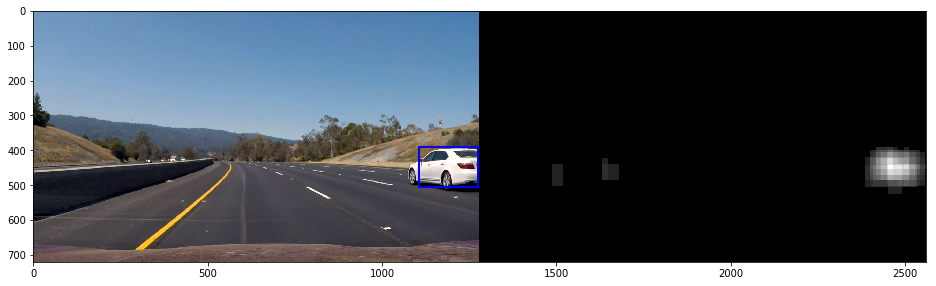

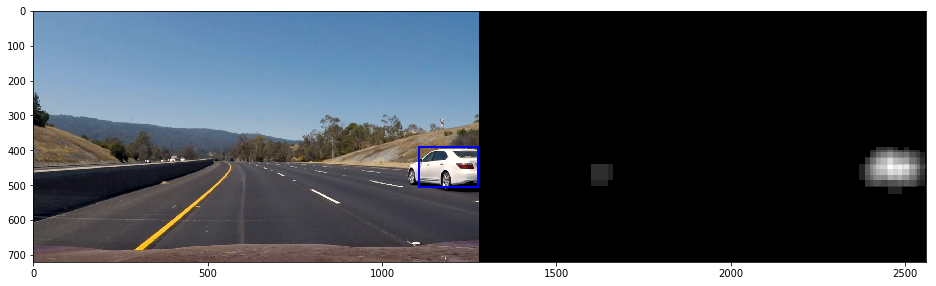

In [4]:
pipeline = CarDetectionPipeline(clf)

for i in range(180,180+20):
    img = cap[i].copy()
    
    plt.figure(figsize=(16,16))
    plt.imshow(pipeline.transform(img))
    plt.show()

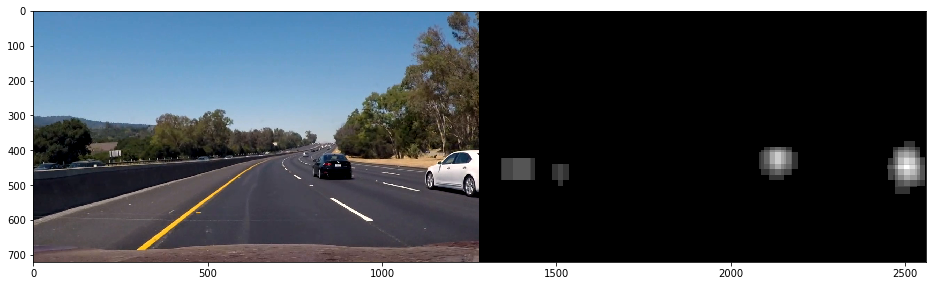

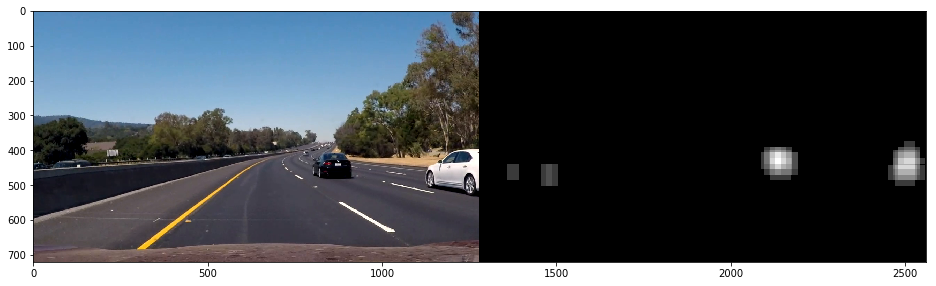

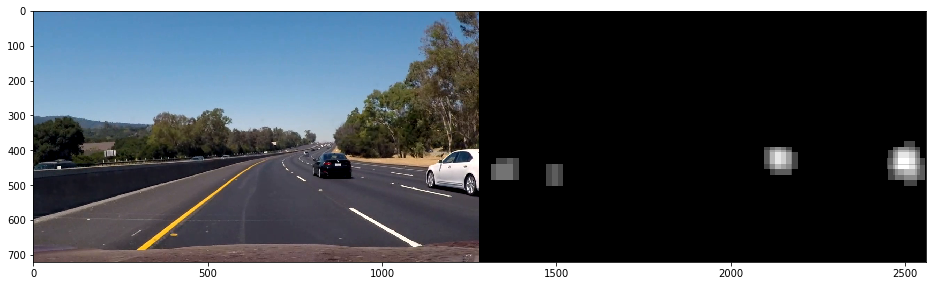

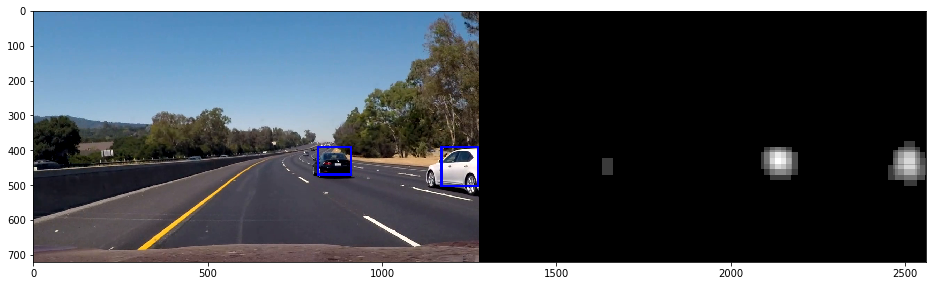

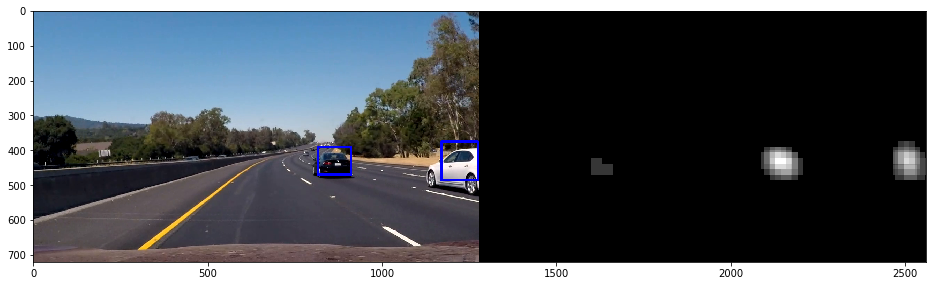

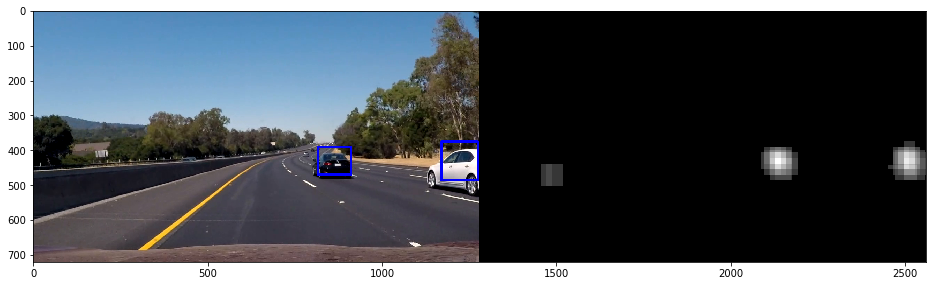

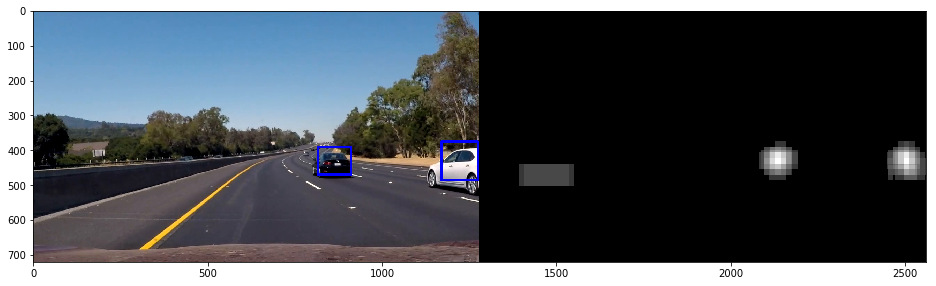

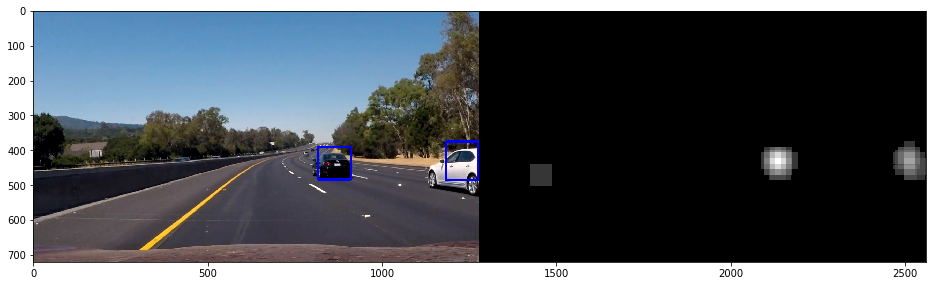

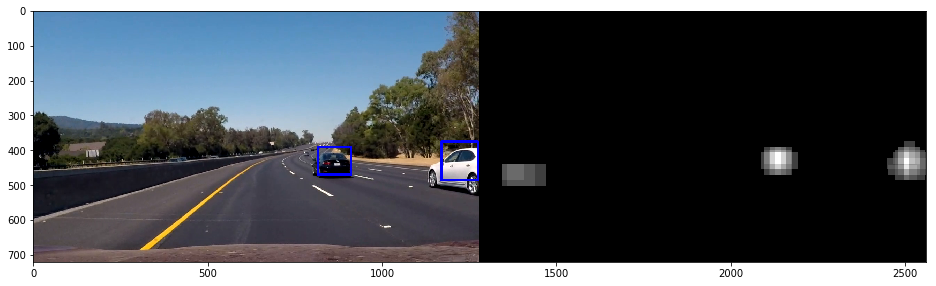

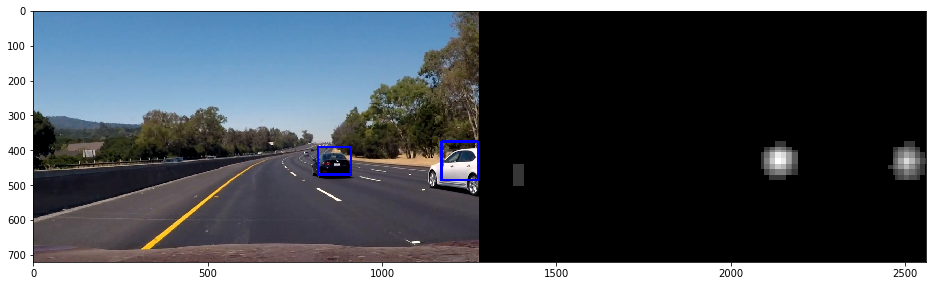

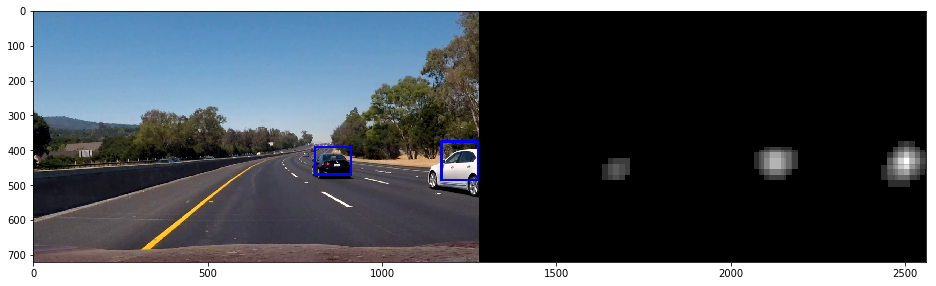

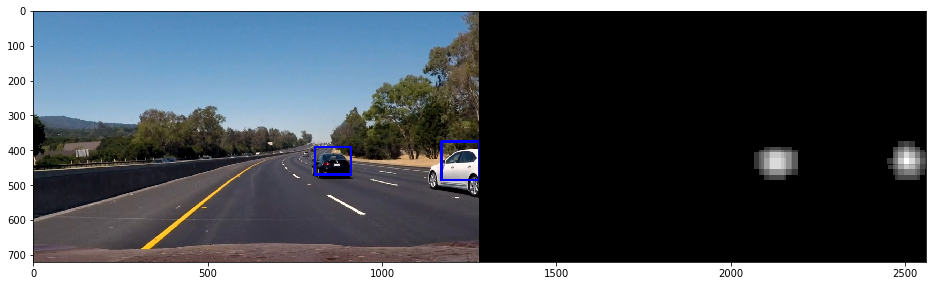

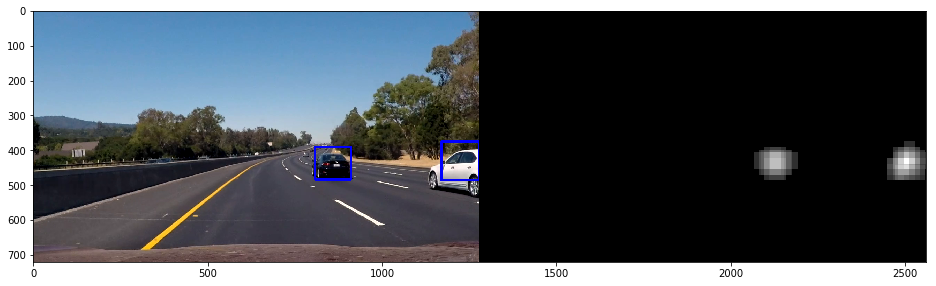

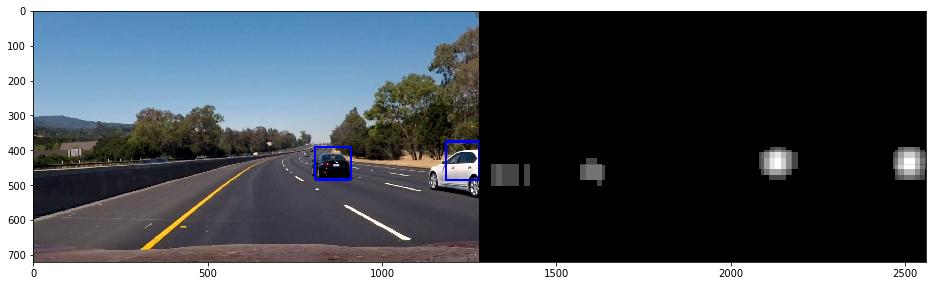

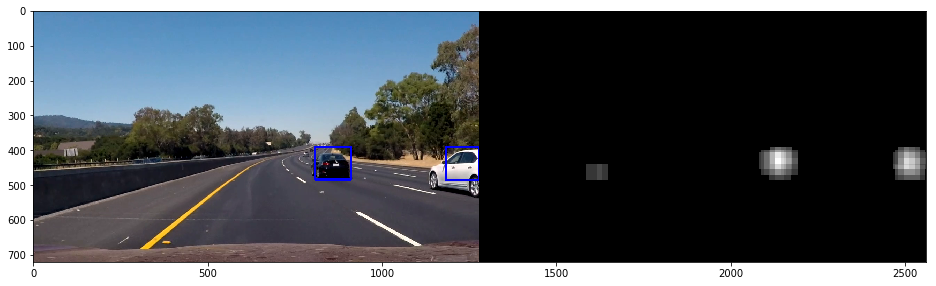

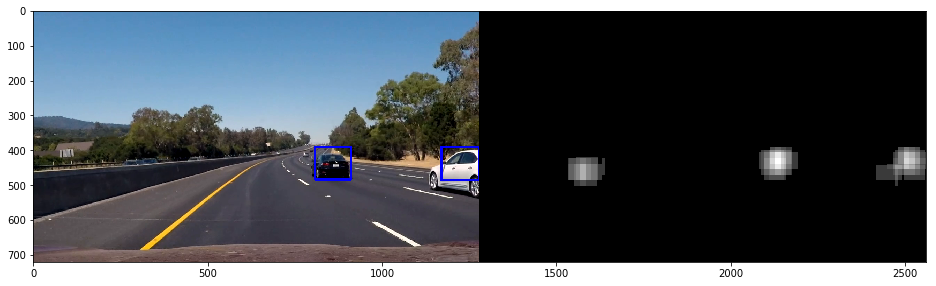

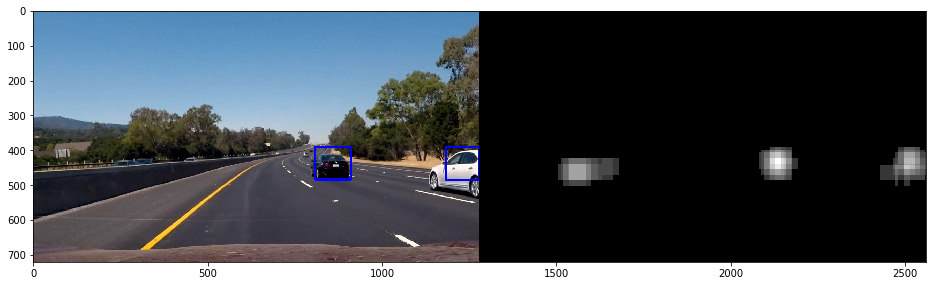

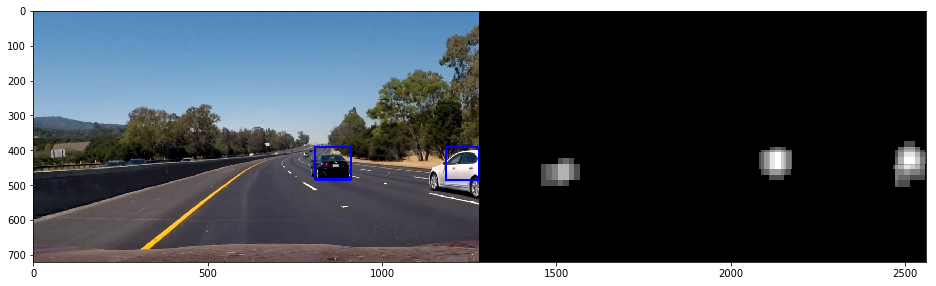

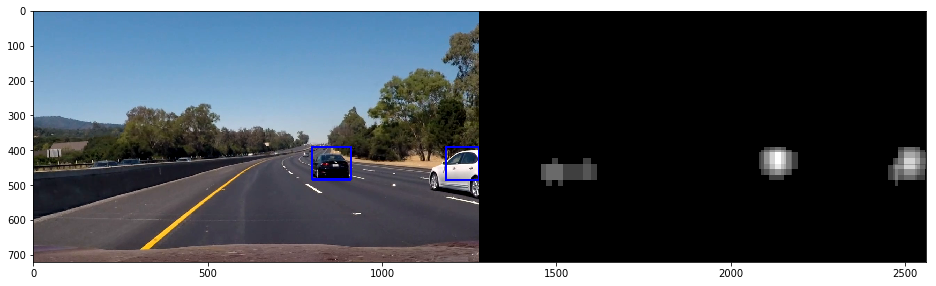

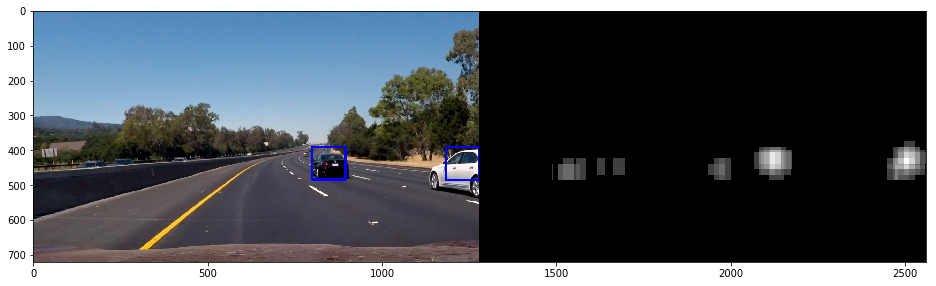

In [5]:
pipeline = CarDetectionPipeline(clf)

for i in range(1100,1100+20):
    img = cap[i].copy()
    
    plt.figure(figsize=(16,16))
    plt.imshow(pipeline.transform(img))
    plt.show()

The above examples shows ow the detection happens, and the threahsholding on the right heat map is what creates the blue bounding boxes on the left side.  

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipeline = CarDetectionPipeline(clf)

project_output = 'project_video_transformed.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_output_clip = clip1.fl_image(lambda x: pipeline.transform(x))

%time project_output_clip.write_videofile(project_output, audio=False, codec='mpeg4')

[MoviePy] >>>> Building video project_video_transformed.mp4
[MoviePy] Writing video project_video_transformed.mp4


100%|█████████▉| 1260/1261 [17:47<00:00,  1.18it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_transformed.mp4 

CPU times: user 1h 40min 18s, sys: 1min 34s, total: 1h 41min 52s
Wall time: 17min 47s


# Limitations and Improvements

This process has a number of limiatations.  The sliding window search, especially since my model also uses color and spacial featurs, requires a processing in each window.  This process could not be done in real time.  It is current running on my laptop at 1 interation per second.  Having less refined searches that speed up the processing lead to issues with both detections accuracy, especially the size of the bounding box, as well as the false positive detection.   

One options is to creat a pipeline that only processes every nth frame, and overlay that detection over several frames.  Another option is to paralleize parts of the img processing and/or use a gpu model that will allow for faster detection inference.  